### Mercari Price 
The files consist of a list of product listings. These files are tab-delimited.

Fields:
- train_id or test_id - the id of the listing

- name - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid  leakage. These removed prices are represented as [rm]

- item_condition_id - the condition of the items provided by the seller

- category_name - category of the listing

- brand_name

- price - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.

- shipping - 1 if shipping fee is paid by seller and 0 by buyer

- item_description - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

In [1]:
import pandas as pd
import numpy as np

from nltk.tokenize import word_tokenize
import nltk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow.keras.backend as K


from tqdm._tqdm_notebook import tqdm_notebook

import os
import itertools

import matplotlib.pyplot as plt
import itertools
from collections import Counter
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import Dense, Input, Embedding, Concatenate, Flatten, Dropout, LSTM, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from nltk.corpus import stopwords
import string

import pickle

from tensorflow.keras.preprocessing.text import text_to_word_sequence 
from nltk.stem import WordNetLemmatizer 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  


In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')


stop_words = set(stopwords.words('english'))
stop_words.remove("no")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tqdm_notebook.pandas()

In [ ]:
#! pip install pydot graphviz

### Dataset download

In [ ]:
# check if in colab
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    print("Running in colab")
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    colab_root = '/content/drive'
    root_dir = "/content/gdrive/My Drive/"
    base_dir = root_dir + 'project-mercari-price/'
    if not os.path.isdir(base_dir):
        os.mkdir(base_dir)
else:
    root_dir= os.getcwd()
    base_dir = root_dir
    
os.chdir(base_dir)

Running in colab
Mounted at /content/gdrive


In [ ]:
dataset_downloaded_path = os.path.join(base_dir, "dataset_downloaded.ignore")
dataset_downloaded = os.path.isfile(dataset_downloaded_path)
dataset_downloaded

True

In [ ]:
if not dataset_downloaded:
  # install kaggle to download dataset
  ! pip install kaggle python-dotenv

In [ ]:
# set to True if you want to save kaggle credentials into a .env file
persist_credentials = False

if not dataset_downloaded:
  # create .env file containing KAGGLE_USER and KAGGLE_KEY
    kaggle_env = os.path.join(base_dir, '.env')
    if not os.path.isfile(kaggle_env):
        with open(kaggle_env, 'w') as envfile:
            kaggle_user = input("Insert kaggle username")
            kaggle_key = input("Insert kaggle key; generate one from kaggle account")
        if persist_credentials:
            envfile.write(f"""
            KAGGLE_USERNAME={kaggle_user}
            KAGGLE_KEY={kaggle_key}
            """)

        # set env vars
        os.environ["KAGGLE_USERNAME"] = kaggle_user
        os.environ["KAGGLE_KEY"] = kaggle_key

        del kaggle_user
        del kaggle_key

In [ ]:
if not dataset_downloaded:
  # loading env vars if .env file exists
    if os.path.isfile(kaggle_env):
        from dotenv import load_dotenv
        load_dotenv(dotenv_path=kaggle_env)
    print(os.environ.get("KAGGLE_USERNAME"))

In [ ]:
if not dataset_downloaded:
    # download and extract dataset
    ! kaggle competitions download -c mercari-price-suggestion-challenge

    # create file so that we know we already downloaded
    with open(dataset_downloaded_path, 'w') as dd_file:
        dataset_downloaded = True
        dd_file.write("")

    print('cwd: ', os.getcwd())
    
    os.listdir()

In [ ]:
if not dataset_downloaded:
    ! 7z x train.tsv.7z
    ! 7z x test.tsv.7z

In [ ]:
os.listdir()

['train.tsv',
 'test.tsv',
 '.env',
 'dataset_downloaded.ignore',
 'MercariPrice.ipynb',
 'Untitled0.ipynb',
 'model.png',
 'MercariPrice1.ipynb']

## Load dataset

In [ ]:
dtypes={
    'name': 'string',
    'item_condition_id': 'int32',
    'category_name': 'string',
    'brand_name': 'string',
    'price': 'float',
    'shipping': 'int32',
    'item_description': 'string'
}
data = pd.read_csv("train.tsv", sep='\t', dtype=dtypes)
data = data.drop(columns=["train_id"])
data

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,<NA>,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,<NA>,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,<NA>,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...
1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,<NA>,12.0,0,"Used once or twice, still in great shape."
1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,<NA>,45.0,1,There is 2 of each one that you see! So 2 red ...


In [ ]:
dtypes={
    'name': 'string',
    'item_condition_id': 'int32',
    'category_name': 'string',
    'brand_name': 'string',
    'price': 'float',
    'shipping': 'int32',
    'item_description': 'string'
}
test = pd.read_csv("test.tsv", sep='\t', dtype=dtypes)
test = test.drop(columns=["test_id"])
test

,name,item_condition_id,category_name,brand_name,shipping,item_description
0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,<NA>,1,Size 7
1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,<NA>,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,Floral Kimono,2,Women/Sweaters/Cardigan,<NA>,0,-floral kimono -never worn -lightweight and pe...
4,Life after Death,3,Other/Books/Religion & Spirituality,<NA>,1,Rediscovering life after the loss of a loved o...
...,...,...,...,...,...,...
693354,Quartz crystal on Flint stone,1,Home/Home Décor/Home Décor Accents,<NA>,0,Flint/Quartz cluster. Self mined ✨measures 3x2...
693355,It Cosmetics - Travel Bundle,1,Beauty/Makeup/Makeup Sets,IT Cosmetics,1,It Cosmetics travel bundle. Includes: Brow pow...
693356,Galaxy S8 hard shell case,1,"Electronics/Cell Phones & Accessories/Cases, C...",<NA>,1,New. Free shipping Basstop case
693357,Hi low floral kimono,2,Women/Swimwear/Cover-Ups,<NA>,0,Floral kimono. Tropical print. Open front. Hi ...


In [ ]:
data.dtypes

name                  string
item_condition_id      int32
category_name         string
brand_name            string
price                float64
shipping               int32
item_description      string
dtype: object

In [ ]:
data.shape

(1482535, 7)

In [ ]:
for column in data.columns:
    print("number of null value in {} : {}".format(column,data[column].isnull().sum()))

number of null value in name : 0
number of null value in item_condition_id : 0
number of null value in category_name : 6327
number of null value in brand_name : 632682
number of null value in price : 0
number of null value in shipping : 0
number of null value in item_description : 4


In [ ]:
for column in test.columns:
    print("number of null value in {} : {}".format(column,test[column].isnull().sum()))

number of null value in name : 0
number of null value in item_condition_id : 0
number of null value in category_name : 3058
number of null value in brand_name : 295525
number of null value in shipping : 0
number of null value in item_description : 0


In [ ]:
data["category_name"].value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
                                                  ...  
Other/Magazines/International Publications            1
Other/Pet Supplies/Pet Food                           1
Handmade/Woodworking/Seasonal                         1
Home/Kids' Home Store/Nursery Furniture               1
Handmade/Accessories/Mirror                           1
Name: category_name, Length: 1287, dtype: Int64

In [ ]:
data["price"].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

https://www.mercari.com/us/help_center/article/69

In [ ]:
len(data[data["price"]<5])

35716

In [ ]:
data=data[data["price"]>=5]

In [ ]:
data = data[data["item_description"].notna()]
data["brand_name"] = data["brand_name"].fillna(value="NA")
data["category_name"] = data["category_name"].fillna(value="NA")
# see warnings -> inplace?
data.shape

(1446815, 7)

In [ ]:
test["brand_name"] = test["brand_name"].fillna(value="NA")
test["category_name"] = test["category_name"].fillna(value="NA")
# see warnings -> inplace?
test.shape

(693359, 6)

In [ ]:
def flat_list(l):
    return  [item for sublist in l for item in sublist]


def plot_common_tokens(tokens, title, n=20):
    sentences = (list(itertools.chain(tokens)))
    flat_sentences = flat_list(sentences)
    counts = Counter(flat_sentences)
    #print(counts.most_common(30))
    common_words = [word[0] for word in counts.most_common(n)]
    common_counts = [word[1] for word in counts.most_common(n)]
    fig = plt.figure(figsize=(18,6))
    sns.barplot(x=common_words, y=common_counts)
    plt.title(title)
    plt.show()


In [ ]:
#plot_common_tokens(data["item_description_tokens"], "Most Common Tokens from Descriptions")

In [ ]:
data

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NA,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NA,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NA,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...
1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NA,12.0,0,"Used once or twice, still in great shape."
1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NA,45.0,1,There is 2 of each one that you see! So 2 red ...


In [ ]:
class LabelEncoder:
  def __init__(self, unknown = 0, invUnknown = 'unknown'):
    self.leDict = {}
    self.invDict = {}
    self.unknown = unknown
    self.invUnknown = invUnknown

  def fit(self, data):
    vci = pd.value_counts(data).index
    self.leDict = dict(zip(vci, range(1, len(vci)+1)))
    self.invDict = dict(zip(range(1, len(vci)+1), vci))

  def transform1(self, item):
    return self.leDict.get(item, self.unknown)

  def transform(self, data):
    return data.apply(lambda item: self.transform1(item))

  def inverse_transform1(self, item):
    return self.invDict.get(item, self.invUnknown)

  def inverse_transform(self, data):
    return data.apply(lambda item: self.inverse_transform1(item))

In [ ]:
cat_le = LabelEncoder()
cat_le.fit(np.hstack([data["category_name"], test["category_name"]]))

data["category_name_l"] = cat_le.transform(data["category_name"])
test["category_name_l"] = cat_le.transform(test["category_name"])

In [ ]:
brand_le = LabelEncoder()
brand_le.fit(np.hstack([data["brand_name"], test["category_name"]]))

data["brand_name_l"] = brand_le.transform(data["brand_name"])
test["brand_name_l"] = brand_le.transform(test["brand_name"])

In [ ]:
data["item_description"]=data["item_description"].str.lower()
data["name"]=data["name"].str.lower()
data.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_name_l,brand_name_l
0,mlb cincinnati reds t shirt size xl,3,Men/Tops/T-shirts,NA,10.0,1,no description yet,19,1
1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,this keyboard is in great condition and works ...,242,585
2,ava-viv blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,adorable top with a hint of lace and a key hol...,10,85
3,leather horse statues,1,Home/Home Décor/Home Décor Accents,NA,35.0,1,new with tags. leather horses. retail for [rm]...,28,1
4,24k gold plated rose,1,Women/Jewelry/Necklaces,NA,44.0,0,complete with certificate of authenticity,16,1


In [ ]:
test["item_description"]=test["item_description"].str.lower()
test["name"]=test["name"].str.lower()
test.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description,category_name_l,brand_name_l
0,"breast cancer ""i fight like a girl"" ring",1,Women/Jewelry/Rings,NA,1,size 7,34,1
1,"25 pcs new 7.5""x12"" kraft bubble mailers",1,Other/Office supplies/Shipping Supplies,NA,1,"25 pcs new 7.5""x12"" kraft bubble mailers lined...",79,1
2,coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,brand new coach bag. bought for [rm] at a coac...,203,21
3,floral kimono,2,Women/Sweaters/Cardigan,NA,0,-floral kimono -never worn -lightweight and pe...,45,1
4,life after death,3,Other/Books/Religion & Spirituality,NA,1,rediscovering life after the loss of a loved o...,442,1


In [ ]:
def list_to_str(l):
   return ' '.join([str(elem) for elem in l])
   
def textCleanup(df):
  df=df.to_frame(name="str")
  df["clean"] = df["str"].progress_apply(text_to_word_sequence)   # 20 secondi

  lemmatizer = WordNetLemmatizer() 
  
  df["clean"] = df["clean"].progress_apply(lambda sentence : [lemmatizer.lemmatize(word) for word in sentence if word not in stop_words]) # 10 secondi
  df["clean"] = df["clean"].progress_apply(list_to_str) # 6 secondi
  return df["clean"]

In [ ]:
def preprocessData(data):
  print('description clean up')
  data["item_description_clean"] = textCleanup(data["item_description"]) 

  print('name clean up')
  data["name_clean"] = textCleanup(data["name"])
  
  return data

In [ ]:
def tokenizeData(df, description, name, tokenizer= None, texts= None):
  if tokenizer == None:
    tokenizer = Tokenizer()

    print("fit tokenizer")
    tokenizer.fit_on_texts(texts)
  
  print('tokenize description')
  df["item_description_t"]=tokenizer.texts_to_sequences(df[description])

  print('tokenize name')
  df["name_t"]=tokenizer.texts_to_sequences(df[name])
  return df, tokenizer

In [ ]:
data = preprocessData(data)
data.head()

description clean up



name clean up


,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_name_l,brand_name_l,item_description_clean,name_clean
0,mlb cincinnati reds t shirt size xl,3,Men/Tops/T-shirts,NA,10.0,1,no description yet,19,1,no description yet,mlb cincinnati red shirt size xl
1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,this keyboard is in great condition and works ...,246,1073,keyboard great condition work like came box po...,razer blackwidow chroma keyboard
2,ava-viv blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,adorable top with a hint of lace and a key hol...,10,175,adorable top hint lace key hole back pale pink...,ava viv blouse
3,leather horse statues,1,Home/Home Décor/Home Décor Accents,NA,35.0,1,new with tags. leather horses. retail for [rm]...,28,1,new tag leather horse retail rm stand foot hig...,leather horse statue
4,24k gold plated rose,1,Women/Jewelry/Necklaces,NA,44.0,0,complete with certificate of authenticity,16,1,complete certificate authenticity,24k gold plated rose


In [ ]:
test = preprocessData(test)
test.head()

description clean up



name clean up


,name,item_condition_id,category_name,brand_name,shipping,item_description,brand_name_l,category_name_l,item_description_clean,name_clean
0,"breast cancer ""i fight like a girl"" ring",1,Women/Jewelry/Rings,NA,1,size 7,1,34,size 7,breast cancer fight like girl ring
1,"25 pcs new 7.5""x12"" kraft bubble mailers",1,Other/Office supplies/Shipping Supplies,NA,1,"25 pcs new 7.5""x12"" kraft bubble mailers lined...",1,79,25 pc new 7 5 x12 kraft bubble mailer lined bu...,25 pc new 7 5 x12 kraft bubble mailer
2,coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,brand new coach bag. bought for [rm] at a coac...,21,203,brand new coach bag bought rm coach outlet,coach bag
3,floral kimono,2,Women/Sweaters/Cardigan,NA,0,-floral kimono -never worn -lightweight and pe...,1,45,floral kimono never worn lightweight perfect h...,floral kimono
4,life after death,3,Other/Books/Religion & Spirituality,NA,1,rediscovering life after the loss of a loved o...,1,442,rediscovering life loss loved one tony cooke p...,life death


In [ ]:
texts = np.hstack([data["item_description"], data["name"]])

data, tokenizer = tokenizeData(data ,"item_description" ,"name", None, texts)

fit tokenizer
tokenize description
tokenize name


In [ ]:
final_data=data[["item_condition_id","shipping","category_name_l","brand_name_l", "item_description_t", "name_t", "price"]]
final_data

,item_condition_id,shipping,category_name_l,brand_name_l,item_description,name,price
0,3,1,19,1,no description yet,mlb cincinnati reds t shirt size xl,10.0
1,3,0,242,585,this keyboard is in great condition and works ...,razer blackwidow chroma keyboard,52.0
2,1,1,10,85,adorable top with a hint of lace and a key hol...,ava-viv blouse,10.0
3,1,1,28,1,new with tags. leather horses. retail for [rm]...,leather horse statues,35.0
4,1,0,16,1,complete with certificate of authenticity,24k gold plated rose,44.0
...,...,...,...,...,...,...,...
1482530,2,1,243,46,"lace, says size small but fits medium perfectl...",free people inspired dress,20.0
1482531,2,0,122,16,little mermaid handmade dress never worn size 2t,little mermaid handmade dress,14.0
1482532,2,0,86,1,"used once or twice, still in great shape.",21 day fix containers and eating plan,12.0
1482533,3,1,28,1,there is 2 of each one that you see! so 2 red ...,world markets lanterns,45.0


In [ ]:
test, _ = tokenizeData(test ,"item_description", "name", tokenizer)

tokenize description
tokenize name


In [ ]:
final_test=test[["item_condition_id","shipping","category_name_l","brand_name_l", "item_description_t", "name_t"]]
final_test

,item_condition_id,shipping,category_name_l,brand_name_l,item_description_t,name_t
0,1,1,34,1,"[2, 36]","[1470, 3174, 81800, 4094, 28, 87, 171]"
1,1,1,79,1,"[367, 1, 36, 16, 7878, 4705, 493, 621, 493, 45...","[367, 1, 36, 16, 7878, 4705, 493]"
2,1,1,203,21,"[5, 1, 247, 57, 155, 9, 38213, 247, 2990]","[247, 57]"
3,2,0,45,1,"[227, 1959, 21, 14, 482, 60, 288, 1652]","[227, 1959]"
4,3,1,442,1,"[100074, 389, 1342, 966, 23, 3708, 53311, 3557...","[389, 4641]"
...,...,...,...,...,...,...
693354,1,0,28,1,"[11633, 1940, 6560, 754, 38303, 39541, 147079,...","[1940, 568, 11633, 479]"
693355,1,1,62,282,"[382, 10, 126, 751, 523, 7103, 1930, 158, 3919...","[382, 10]"
693356,1,1,7,1,"[1, 4, 7, 58181, 43]","[372, 2853, 334, 1295, 43]"
693357,2,0,249,1,"[227, 1959, 2162, 163, 318, 137, 1308, 264, 18...","[1308, 264, 227, 1959]"


In [ ]:
train, validation = train_test_split(final_data, test_size=0.2, random_state=1000)

In [ ]:
'''desc_vocab_size = len(t['item_description'].word_index) + 1
print(desc_vocab_size)

name_vocab_size = len(t['name'].word_index) + 1
print(name_vocab_size)'''
vocab_size= len(tokenizer.word_index)+1
print(vocab_size)

255431


In [ ]:
def lengthCumDistribution(data, threshold=0.8):
  lengths = data.apply(lambda x: len(x))
  lengthsHist = lengths.hist
  lengthsFreq = lengths.value_counts().sort_index()
  lengthsFreqNormalized = lengthsFreq / sum(lengthsFreq)
  lengthsCumFreq = lengthsFreqNormalized.cumsum()

  index = lengthsCumFreq.where(lengthsCumFreq >= threshold).first_valid_index()

  cumPlot = lengthsCumFreq.plot

  return index, lengthsCumFreq, cumPlot, lengthsHist

In [ ]:
train[["item_description_t","name_t"]]

,item_description_t,name_t
233645,"[15, 51, 16, 314, 2273, 146, 314, 1597, 5, 1, ...","[51, 16]"
1419447,"[5, 1, 64, 18, 96, 161]","[145, 1767, 3089, 2485, 64]"
935662,"[100, 15, 6, 1258, 7074, 379, 32, 2, 39, 376, ...","[7074, 379, 32, 39]"
1147679,"[21, 15]",[8489]
766955,"[331, 44, 79, 5, 1, 21, 15]","[5269, 135, 1176]"
...,...,...
19252,"[3, 29, 489]","[413, 245, 1943, 174, 4825]"
385322,"[755, 707, 4495, 292, 313, 70]","[117, 755, 707, 4495, 292]"
138223,"[88, 12, 2, 39, 72, 99, 1873, 455, 22, 6, 174,...","[87, 1873, 455]"
1148150,"[267, 15, 7525, 51, 20, 82, 43, 256, 91, 9, 10...","[7525, 51, 20, 82, 147, 43]"


In [ ]:
desc_length_max=75
inputDesc_train = pad_sequences(train["item_description_t"],
                                                  padding='post', maxlen=desc_length_max)

In [ ]:
inputDesc_validation = pad_sequences(validation["item_description_t"],
                                                  padding='post', maxlen=desc_length_max)

In [ ]:
name_length_max=10
inputName_train = pad_sequences(train["name_t"], padding='post', maxlen=name_length_max)

In [ ]:
inputName_validation = pad_sequences(validation["name_t"], padding='post', maxlen=name_length_max)

In [ ]:
y_train = train["price"]
y_train

233645     105.0
1419447     16.0
935662      26.0
1147679     14.0
766955       8.0
           ...  
19252       18.0
385322      54.0
138223      23.0
1148150     14.0
1185228     18.0
Name: price, Length: 1157452, dtype: float64

In [ ]:
y_validation = validation["price"]
y_validation

1378349     39.0
1186437     14.0
1356070    559.0
981120      54.0
1017699     25.0
           ...  
933953      10.0
1246650     30.0
1415233     10.0
376025      28.0
511335      19.0
Name: price, Length: 289363, dtype: float64

In [ ]:
train.head()

,item_condition_id,shipping,category_name_l,brand_name_l,item_description_t,name_t,price
233645,4,1,42,8,"[31, 77, 617, 400, 10, 2522, 784, 5, 400, 1839...","[77, 617]",105.0
1419447,1,0,6,1,"[16, 4, 100, 48, 134, 207]","[230, 1968, 3491, 2821, 100]",16.0
935662,3,1,29,1136,"[138, 31, 17, 1387, 7943, 462, 60, 6, 66, 841,...","[7943, 462, 60, 66]",26.0
1147679,2,0,78,1,"[36, 31]",[9700],14.0
766955,1,1,4,18,"[415, 2, 71, 14, 2, 216, 16, 4, 36, 31]","[5926, 212, 1407]",8.0


In [ ]:
inputA_train = train[["item_condition_id", "category_name_l", "brand_name_l", "shipping"]].values.astype('int32')

In [ ]:
inputA_validation = validation[["item_condition_id", "category_name_l", "brand_name_l", "shipping"]].values.astype('int32')

In [ ]:
name_vocab_size= vocab_size
desc_vocab_size= vocab_size
def getModel():
    inputA = Input(shape=(4,))
    #Ad = Dense(4, activation='relu')(inputA)
    Ad = inputA
    
    inputName = Input(shape=(name_length_max,))
    Ne = Embedding(input_dim=name_vocab_size, output_dim=8, input_length=name_length_max)(inputName)
    #Ne = Embedding(
    #    num_tokens,
    #    embedding_dim,
    #    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    #    trainable=False,
    #)(inputName)
    Nd = LSTM(12,return_sequences=True)(Ne)
    Nd = Flatten()(Nd)

    #Nd = Nf
    
    inputDesc = Input(shape=(desc_length_max,))
    De = Embedding(input_dim=desc_vocab_size, output_dim=16, input_length=desc_length_max)(inputDesc)
    #De = Embedding(
    #    num_tokens,
    #    embedding_dim,
    #    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    #    trainable=False,
    #)(inputDesc)
    Dd = LSTM(16,return_sequences=True)(De)
    Dd = LSTM(8,return_sequences=True)(Dd)
    Dd = Flatten()(Dd)
    #Dd = Df
    
    concat = Concatenate()([Ad, Nd, Dd])

    x = Dropout(0.1)(concat)    
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(16, activation='relu')(x)
    
    x = Dense(1, activation='linear')(x)
    
    model = Model(inputs=[inputA, inputName, inputDesc], outputs=x)
    
    return model
    

In [ ]:
model = getModel()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 75)]         0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 75, 16)       4086896     input_12[0][0]                   
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 10, 8)        2043448     input_11[0][0]                   
______________________________________________________________________________________________

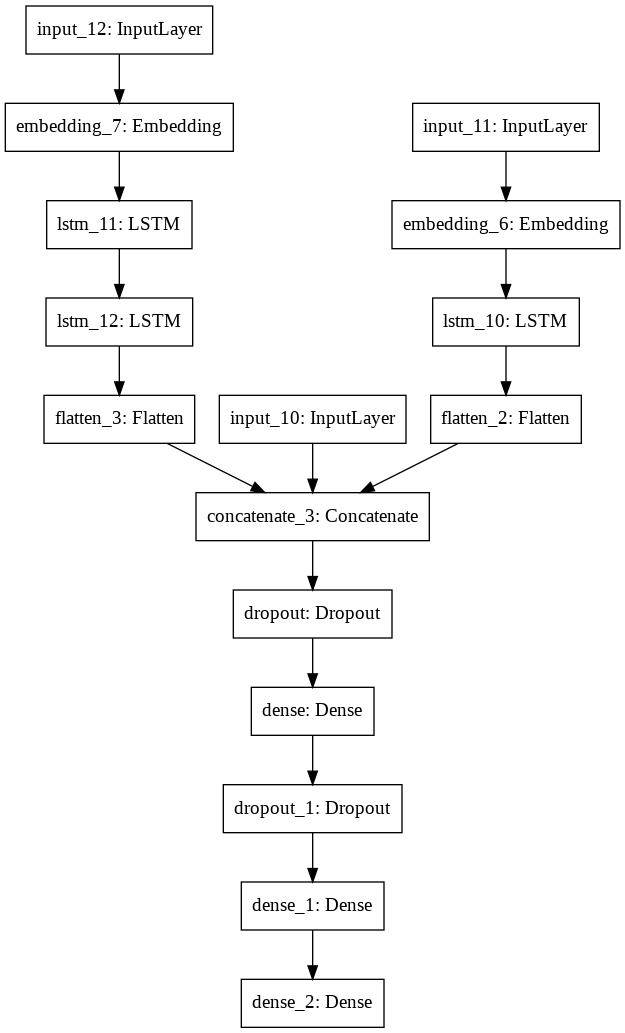

In [ ]:
plot_model(model)

In [ ]:
import keras.backend as K
msle = tf.keras.losses.MeanSquaredLogarithmicError()

def root_mean_squared_logarithmic_error(y_true, y_pred):
    return K.sqrt(msle(y_true, y_pred))

In [ ]:
model.compile(loss = root_mean_squared_logarithmic_error, optimizer='adam', metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError(), 'mean_squared_logarithmic_error', root_mean_squared_logarithmic_error])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(x=[inputA_train, inputName_train, inputDesc_train], y=y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=([inputA_validation, inputName_validation, inputDesc_validation], y_validation),
                    callbacks=[callback],
                    batch_size=512)
# senza pulizia  val_root_mean_squared_logarithmic_error: 0.4701 e loss: 0.3637
# con pulizia val_root_mean_squared_logarithmic_error: 0.4670 e loss: 0.3699

Epoch 1/50
2261/2261 [==============================] - 142s 63ms/step - loss: 0.4077 - mse: 662.7835 - mae: 9.3528 - root_mean_squared_error: 25.7446 - mean_squared_logarithmic_error: 0.1666 - root_mean_squared_logarithmic_error: 0.4077 - val_loss: 0.4823 - val_mse: 773.4593 - val_mae: 10.8778 - val_root_mean_squared_error: 27.8111 - val_mean_squared_logarithmic_error: 0.2331 - val_root_mean_squared_logarithmic_error: 0.4824
Epoch 2/50
2261/2261 [==============================] - 142s 63ms/step - loss: 0.3986 - mse: 622.9674 - mae: 9.0806 - root_mean_squared_error: 24.9593 - mean_squared_logarithmic_error: 0.1592 - root_mean_squared_logarithmic_error: 0.3986 - val_loss: 0.4737 - val_mse: 771.6238 - val_mae: 10.7596 - val_root_mean_squared_error: 27.7781 - val_mean_squared_logarithmic_error: 0.2249 - val_root_mean_squared_logarithmic_error: 0.4738
Epoch 3/50
2261/2261 [==============================] - 147s 65ms/step - loss: 0.3904 - mse: 594.5752 - mae: 8.8562 - root_mean_squared_erro

In [ ]:
inputA_test = test[["item_condition_id", "category_name_l", "brand_name_l", "shipping"]].values.astype('int32')
inputName_test = pad_sequences(test["name_t"], padding='post', maxlen=name_length_max)
inputDesc_test = pad_sequences(test["item_description_t"], padding='post', maxlen=desc_length_max)
pred = model.predict([inputA_test, inputName_test, inputDesc_test])
pred

array([[ 8.035739 ],
       [14.065505 ],
       [35.647938 ],
       ...,
       [ 5.6740685],
       [14.204231 ],
       [ 8.982701 ]], dtype=float32)

In [ ]:
import math

def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [ ]:
validation

,item_condition_id,shipping,category_name_l,brand_name_l,item_description_t,name_t,price
1378349,1,1,1,1,"[132, 1147, 2]","[1005, 145, 41, 412, 217, 53]",39.0
1186437,1,0,1,5,"[3, 44, 54]","[217, 41, 53, 62, 295, 40]",14.0
1356070,3,0,166,8,"[1313, 4269, 1866, 406, 9115, 8, 92, 5439, 766...","[1866, 406, 52, 1618, 3023, 12547, 1005, 1333]",559.0
981120,1,0,3,118,"[3744, 374, 32031, 370, 343, 5, 1, 1845, 211, ...","[374, 362, 527, 540, 720]",54.0
1017699,1,1,6,129,"[421, 390, 2035, 2231, 1189, 388, 182, 73896, ...","[1076, 1420, 390, 232873, 672, 232874, 523]",25.0
...,...,...,...,...,...,...,...
933953,1,1,7,1,"[51, 20, 20, 677, 43]","[4, 35, 11415]",10.0
1246650,1,1,15,4,"[84, 49, 7172, 1444, 1799, 2807, 708, 499, 573...","[1444, 1799, 37]",30.0
1415233,3,0,111,25,"[15, 156, 344, 106, 89, 10, 581, 15, 17, 1320,...","[15, 156, 581, 10]",10.0
376025,1,0,152,153,"[122, 66, 99, 9265, 199, 40, 1262, 378, 9757, ...","[1464, 9265, 38]",28.0


In [ ]:
pred=pred.round()

In [ ]:
pred_v = model.predict([inputA_validation, inputName_validation, inputDesc_validation])
pred_v = pred_v.round()

In [ ]:
len(pred_v)

289363

In [ ]:
len(y_validation)

289363

In [ ]:
root_mean_squared_logarithmic_error(y_validation, pred_v)

ResourceExhaustedError: ignored

**Glove**

In [ ]:
#! wget http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip

--2020-12-20 16:29:58--  http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182753 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.00MB/s    in 6m 31s  

2020-12-20 16:36:29 (2.10 MB/s) - ‘glove.6B.zip’ saved [862182753/862182753]



In [ ]:
#! unzip glove.6B.zip glove.6B.100d.txt

Archive:  glove.6B.zip
  inflating: glove.6B.200d.txt       


In [ ]:
word_index = tokenizer.word_index
print(len(word_index))

240579


In [ ]:
if glove:
  path_to_glove_file = os.path.join(
      base_dir, "glove.6B.100d.txt"
  )

  embeddings_index = {}
  with open(path_to_glove_file) as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, "f", sep=" ")
          embeddings_index[word] = coefs

  print("Found %s word vectors." % len(embeddings_index))

Found 400001 word vectors.


In [ ]:
#glove pretrained embedding

if glove:

  num_tokens = len(word_index) + 2
  embedding_dim = 100
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))

Converted 72301 words (168278 misses)


In [ ]:
histDf = pd.DataFrame(history.history)
histDf.tail()

In [ ]:
histDf.plot(y=["loss", "val_loss"])

**Count Vectorizer**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
data.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_name_l,brand_name_l,item_description_clean,name_clean
0,mlb cincinnati reds t shirt size xl,3,Men/Tops/T-shirts,NA,10.0,1,no description yet,19,1,no description yet,mlb cincinnati red shirt size xl
1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,this keyboard is in great condition and works ...,246,1076,keyboard great condition work like came box po...,razer blackwidow chroma keyboard
2,ava-viv blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,adorable top with a hint of lace and a key hol...,10,175,adorable top hint lace key hole back pale pink...,ava viv blouse
3,leather horse statues,1,Home/Home Décor/Home Décor Accents,NA,35.0,1,new with tags. leather horses. retail for [rm]...,28,1,new tag leather horse retail rm stand foot hig...,leather horse statue
4,24k gold plated rose,1,Women/Jewelry/Necklaces,NA,44.0,0,complete with certificate of authenticity,16,1,complete certificate authenticity,24k gold plated rose


In [ ]:
vectorizer_desc = CountVectorizer()
vectorizer_desc.fit(data["item_description_clean"].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
len(vectorizer_desc.vocabulary_)

160142

In [ ]:
train, validation = train_test_split(data, test_size=0.2, random_state=1000)

In [ ]:
description_train = vectorizer_desc.transform(train["item_description_clean"].values)

In [ ]:
description_validation = vectorizer_desc.transform(validation["item_description_clean"].values)

In [ ]:
vectorizer_name = CountVectorizer()
vectorizer_name.fit(data["name_clean"].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
len(vectorizer_name.vocabulary_)

104060

In [ ]:
name_train = vectorizer_name.transform(train["name_clean"].values)
name_validation = vectorizer_name.transform(validation["name_clean"].values)

In [ ]:
categorical_train= train[["item_condition_id","shipping","category_name_l","brand_name_l"]]
print("Train:")
print(categorical_train.head())
print("\nValidation:")
categorical_validation= validation[["item_condition_id","shipping","category_name_l","brand_name_l"]]
print(categorical_validation.head())

Train:
         item_condition_id  shipping  category_name_l  brand_name_l
233645                   4         1               42             8
1419447                  1         0                6             1
935662                   3         1               29          1138
1147679                  2         0               78             1
766955                   1         1                4            18

Validation:
         item_condition_id  shipping  category_name_l  brand_name_l
1378349                  1         1                1             1
1186437                  1         0                1             5
1356070                  3         0              166             8
981120                   1         0                3           118
1017699                  1         1                6           129


In [ ]:
y_train=train["price"].values
y_validation=validation["price"].values

In [ ]:
def getModel_bow():
    inputA = Input(categorical_train.shape[1])
    inputName = Input(name_train.shape[1])
    inputDesc = Input(description_train.shape[1])
    concat = Concatenate()([inputName, inputDesc, inputA])

    x = Dropout(0.1)(concat)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(16, activation='relu')(x)
    
    x = Dense(1, activation='linear')(x)
    
    model = Model(inputs=[inputName ,inputDesc, inputA], outputs=x)

    return model

In [ ]:
model = getModel_bow()
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_74 (InputLayer)           [(None, 99206)]      0                                            
__________________________________________________________________________________________________
input_75 (InputLayer)           [(None, 152484)]     0                                            
__________________________________________________________________________________________________
input_73 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
concatenate_21 (Concatenate)    (None, 251694)       0           input_74[0][0]                   
                                                                 input_75[0][0]            

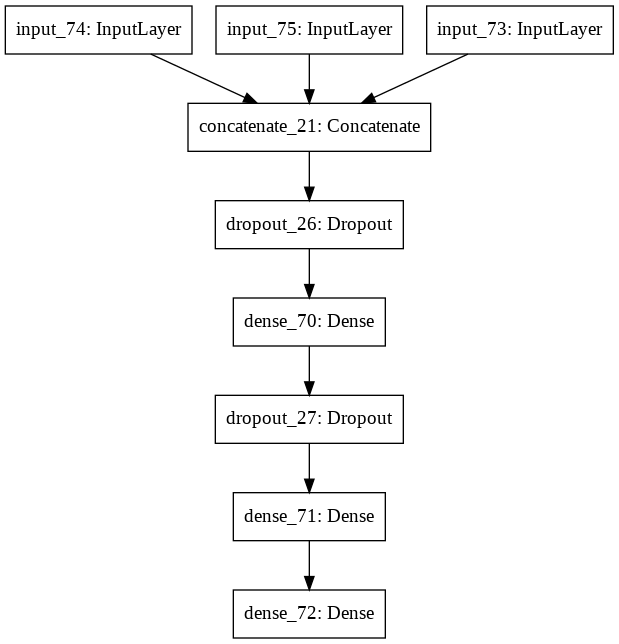

In [ ]:
plot_model(model)

In [ ]:
model.compile(loss = root_mean_squared_logarithmic_error, optimizer='adam', metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError(), 'mean_squared_logarithmic_error', root_mean_squared_logarithmic_error])

In [ ]:
history = model.fit(x=[name_train, description_train, categorical_train.values], y=y_train,
                    epochs=5,
                    verbose=True,
                    validation_data=([name_validation, description_validation, categorical_validation.values], y_validation),
                    batch_size=512)

Epoch 1/5
2261/2261 [==============================] - 409s 180ms/step - loss: 0.8390 - mse: 1579.3568 - mae: 17.1789 - root_mean_squared_error: 39.6382 - mean_squared_logarithmic_error: 0.8935 - root_mean_squared_logarithmic_error: 0.8390 - val_loss: 0.5064 - val_mse: 1061.6251 - val_mae: 11.9426 - val_root_mean_squared_error: 32.5826 - val_mean_squared_logarithmic_error: 0.2570 - val_root_mean_squared_logarithmic_error: 0.5064
Epoch 2/5
2261/2261 [==============================] - 408s 180ms/step - loss: 0.5034 - mse: 1117.7452 - mae: 11.9919 - root_mean_squared_error: 33.4265 - mean_squared_logarithmic_error: 0.2539 - root_mean_squared_logarithmic_error: 0.5034 - val_loss: 0.4772 - val_mse: 948.2609 - val_mae: 11.3124 - val_root_mean_squared_error: 30.7938 - val_mean_squared_logarithmic_error: 0.2282 - val_root_mean_squared_logarithmic_error: 0.4773
Epoch 3/5
2261/2261 [==============================] - 409s 180ms/step - loss: 0.4796 - mse: 992.6749 - mae: 11.3878 - root_mean_square

BOW con pulizia:
loss: 0.4549 - mse: 877.1694 - mae: 10.7754 - root_mean_squared_error: 29.6144 - mean_squared_logarithmic_error: 0.2073 - root_mean_squared_logarithmic_error: 0.4549 - val_loss: 0.4572 - val_mse: 823.4496 - val_mae: 10.7306 - val_root_mean_squared_error: 28.6958 - val_mean_squared_logarithmic_error: 0.2095 - val_root_mean_squared_logarithmic_error: 0.4573

BOW senza pulizia words:
loss: 0.4537 - mse: 892.7444 - mae: 10.7434 - root_mean_squared_error: 29.8743 - mean_squared_logarithmic_error: 0.2063 - root_mean_squared_logarithmic_error: 0.4537 - val_loss: 0.4554 - val_mse: 848.4371 - val_mae: 10.7117 - val_root_mean_squared_error: 29.1279 - val_mean_squared_logarithmic_error: 0.2079 - val_root_mean_squared_logarithmic_error: 0.4555

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    rmsle = history.history['root_mean_squared_logarithmic_error']
    val_rmsle = history.history['val_root_mean_squared_logarithmic_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(rmsle) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, rmsle, 'b', label='Training rmsle')
    plt.plot(x, val_rmsle, 'r', label='Validation rmsle')
    plt.title('Training and validation root_mean_squared_logarithmic_error')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

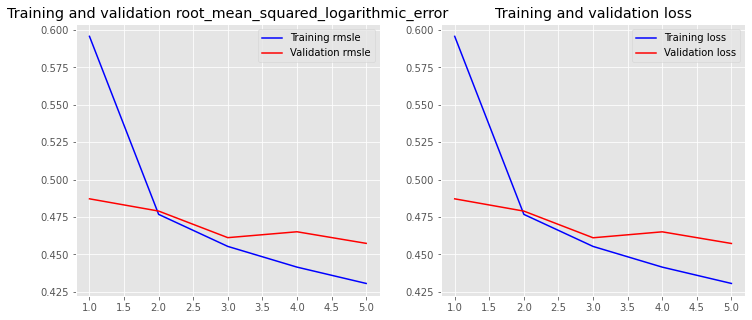

In [ ]:
plot_history(history)

Feature Extraction with Transformers

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModel, pipeline

model = AutoModel.from_pretrained('distilbert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
nlp = pipeline('feature-extraction', model=model, tokenizer=tokenizer)

In [ ]:
train

In [ ]:
ris=nlp(train["item_description"].to_list())